In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from scipy import sparse
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
import lightgbm as lgb
import matplotlib.pyplot as plt
import optuna
from optuna.integration import XGBoostPruningCallback
from optuna.samplers import TPESampler
from xgboost import XGBRegressor

In [2]:
def evaluation_metric(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def nrmse(y_true, y_pred):
    rmse_val = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse_val / (y_true.max() - y_true.min())

def test_error_percentage(score):
    return (score/4104996.104768301) * 100

def rmse(preds, dtrain):
    labels = dtrain.get_label()
    return 'rmse', evaluation_metric(labels, preds), True

def rmse_xgboost(preds, dtrain):
    labels = dtrain.get_label()
    return 'rmse', evaluation_metric(labels, preds)

In [3]:
train = pd.read_csv('train_data_nan.csv', index_col='DateTime')
test = pd.read_csv('test_data_nan.csv', index_col = 'DateTime')

train.fillna(-1, inplace=True)
test.fillna(-1, inplace=True)

all_data = pd.concat([train, test], ignore_index = True)
all_data = all_data.drop(columns=["Day", "Year", "t2m", "power", 
                                  "CloudForm", "GroundState(code)", "PhenomenonNumber",
                                 "Humidity(%)", "Visibility(10m)",
                                 "aerosol"])
all_data['num_missing'] = (all_data == -1).sum(axis=1)

all_data_sprs = sparse.hstack([sparse.csr_matrix(all_data)],
                              format = 'csr')
num_train = len(train)
X = all_data_sprs[:num_train]
X_test = all_data_sprs[num_train:]
y = train['power'].values
y_test = test['power'].values

# LightGBM

In [4]:
lgb_params = {'num_leaves': 17,
             'colsample_bytree': 0.7091234824890884,
             'reg_alpha': 0.7394476479071033,
             'reg_lambda': 7.808480534304585,
             'max_depth': 15,
             'learning_rate': 0.007814528175792283,
             'n_estimators': 2157,
             'min_child_samples': 11,
             'subsample': 0.7249013772087863}

In [5]:
lgb_oof_val_preds = np.zeros(X.shape[0])
lgb_oof_test_preds = np.zeros(X_test.shape[0])

folds = TimeSeriesSplit(n_splits=5)

for train_idx, valid_idx in folds.split(X, y) : 
    X_train, y_train = X[train_idx], y[train_idx]
    X_valid, y_valid = X[valid_idx], y[valid_idx]
    
    lgb_model = LGBMRegressor(**lgb_params) #lgb.
    lgb_model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], 
              callbacks = [lgb.early_stopping(stopping_rounds = 300, verbose = 0)])
    
    lgb_oof_test_preds += lgb_model.predict(X_test)/folds.n_splits
    lgb_oof_val_preds[valid_idx] += lgb_model.predict(X_valid)

    lgb_score = evaluation_metric(y_valid, lgb_oof_val_preds[valid_idx])
    print(f"new fold RMSE: {lgb_score:.4f}")

    lgb_nrmse_score = nrmse(y_valid, lgb_oof_val_preds[valid_idx])
    print(f"new Normalized Validation RMSE: {lgb_nrmse_score:.4f}")

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1408
[LightGBM] [Info] Number of data points in the train set: 5791, number of used features: 14
[LightGBM] [Info] Start training from score 4221853.220515
new fold RMSE: 763264.8558
new Normalized Validation RMSE: 0.0644
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1463
[LightGBM] [Info] Number of data points in the train set: 11581, number of used features: 15
[LightGBM] [Info] Start training from score 4082546.515845
new fold RMSE: 754468.2645
new Normalized Validation RMSE: 0.0629
[LightGBM] [Warning] Auto-choosing row-

In [6]:
# RMSE로 평가
lgb_score = evaluation_metric(y_test, lgb_oof_test_preds)
print(f"test RMSE: {lgb_score:.4f}")
print(f"test error percentage : {test_error_percentage(lgb_score):.4f}")

lgb_nrmse_score = nrmse(y_test, lgb_oof_test_preds)
print(f"Normalized test RMSE: {lgb_nrmse_score:.4f}")

test RMSE: 911215.8919
test error percentage : 22.1977
Normalized test RMSE: 0.0750


# XGBoost

In [7]:
xgb_params = {'eta': 0.9957304355968829, 
              'colsample_bynode': 0.40611009833532513, 
              'colsample_bytree': 0.9623288325539622, 
              'alpha': 0.28681293528875274, 
              'lambda': 4.94306107974444, 
              'gamma': 1, 
              'max_depth': 15, 
              'learning_rate': 0.002404371494323695, 
              'n_estimators': 3652, 
              'min_child_weight': 4, 
              'subsample': 0.5229951560076475}

In [8]:
xgb_oof_val_preds = np.zeros(X.shape[0])
xgb_oof_test_preds = np.zeros(X_test.shape[0])

folds = TimeSeriesSplit(n_splits=5)

for train_idx, valid_idx in folds.split(X, y) : 
    X_train, y_train = X[train_idx], y[train_idx]
    X_valid, y_valid = X[valid_idx], y[valid_idx]
    
    xgb_model = XGBRegressor(**xgb_params) 
    xgb_model.set_params(early_stopping_rounds = 300,
                         eval_metric = 'rmse')
    xgb_model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)],
                 verbose = False)
    
    xgb_oof_test_preds += xgb_model.predict(X_test)/folds.n_splits
    xgb_oof_val_preds[valid_idx] += xgb_model.predict(X_valid)

    xgb_score = evaluation_metric(y_valid, xgb_oof_val_preds[valid_idx])
    print(f"new fold RMSE: {xgb_score:.4f}")

    xgb_nrmse_score = nrmse(y_valid, xgb_oof_val_preds[valid_idx])
    print(f"new Normalized Validation RMSE: {xgb_nrmse_score:.4f}")

new fold RMSE: 767024.7836
new Normalized Validation RMSE: 0.0647
new fold RMSE: 765406.5524
new Normalized Validation RMSE: 0.0638
new fold RMSE: 754228.2005
new Normalized Validation RMSE: 0.0617
new fold RMSE: 809537.4212
new Normalized Validation RMSE: 0.0654
new fold RMSE: 768714.4384
new Normalized Validation RMSE: 0.0640


In [9]:
# RMSE로 평가
xgb_score = evaluation_metric(y_test, xgb_oof_test_preds)
print(f"test RMSE: {xgb_score:.4f}")
print(f"test error percentage : {test_error_percentage(xgb_score):.4f}")

xgb_nrmse_score = nrmse(y_test, xgb_oof_test_preds)
print(f"Normalized test RMSE: {xgb_nrmse_score:.4f}")

test RMSE: 834515.0589
test error percentage : 20.3293
Normalized test RMSE: 0.0687


# Ensemble

In [25]:
oof_test_preds = lgb_oof_test_preds * 0.2 + xgb_oof_test_preds * 0.8

In [26]:
score = evaluation_metric(y_test, oof_test_preds)
print(f"test RMSE: {xgb_score:.4f}")
print(f"test error percentage : {test_error_percentage(xgb_score):.4f}")

nrmse_score = nrmse(y_test, oof_test_preds)
print(f"Normalized test RMSE: {xgb_nrmse_score:.4f}")

test RMSE: 834515.0589
test error percentage : 20.3293
Normalized test RMSE: 0.0687


# Visualization

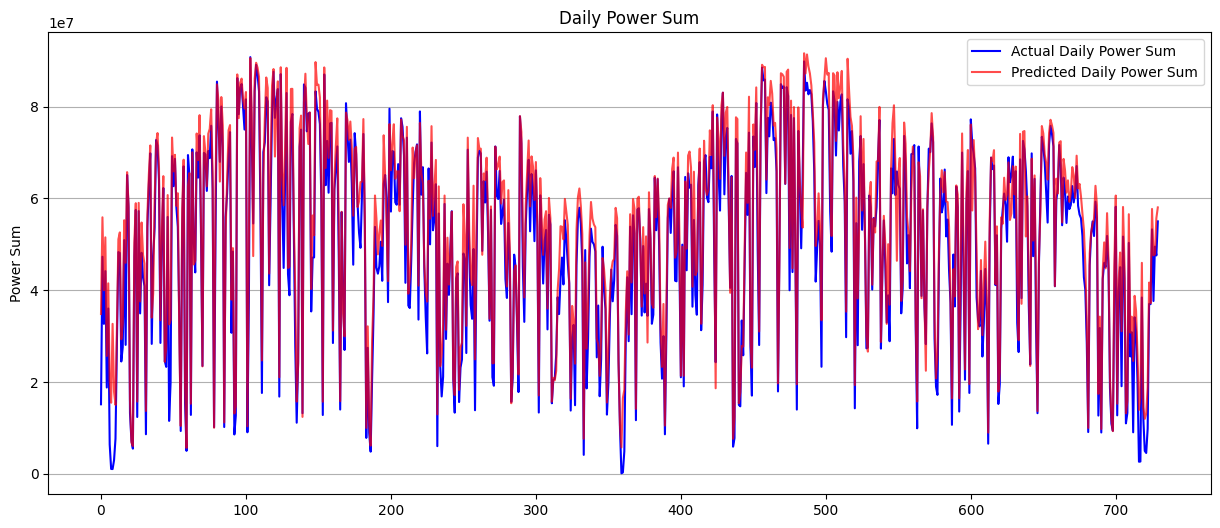

In [24]:
# 예측값 생성

inv_yhat = xgb_oof_test_preds

# DateTime 인덱스를 DatetimeIndex로 변환
test.index = pd.to_datetime(test.index)

# 데이터를 일자별로 그룹화하고 발전량 합계를 계산합니다.
daily_actual_sum = test.groupby(test.index.date)['power'].sum().values
daily_predicted_sum = [np.sum(inv_yhat[test.index.date == date]) for date in np.unique(test.index.date)]

# 꺾은선 그래프로 결과를 표시합니다.
plt.figure(figsize=(15, 6))
plt.plot(daily_actual_sum, label='Actual Daily Power Sum', color='blue')
plt.plot(daily_predicted_sum, label='Predicted Daily Power Sum', color='red', alpha=0.7)
plt.title('Daily Power Sum')
plt.ylabel('Power Sum')
plt.legend()
plt.grid(True, axis='y')
plt.show()

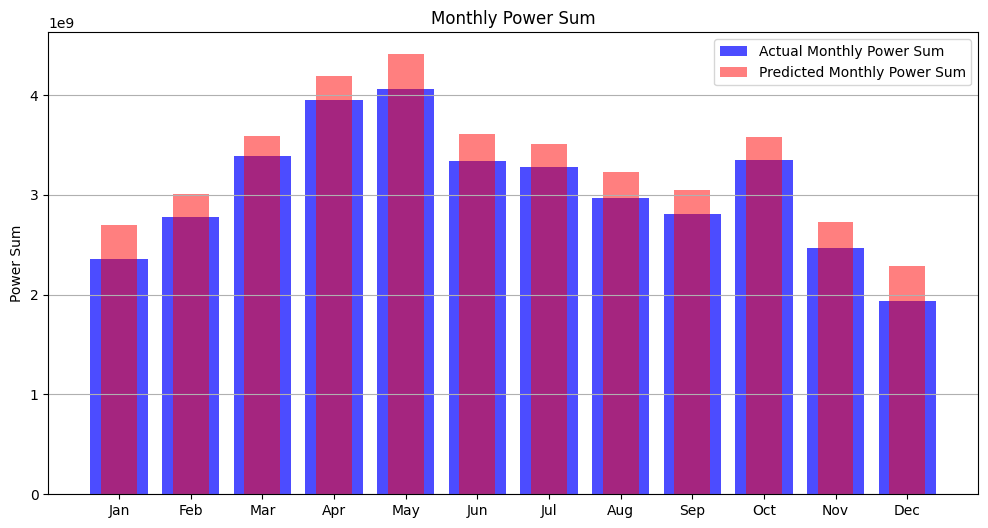

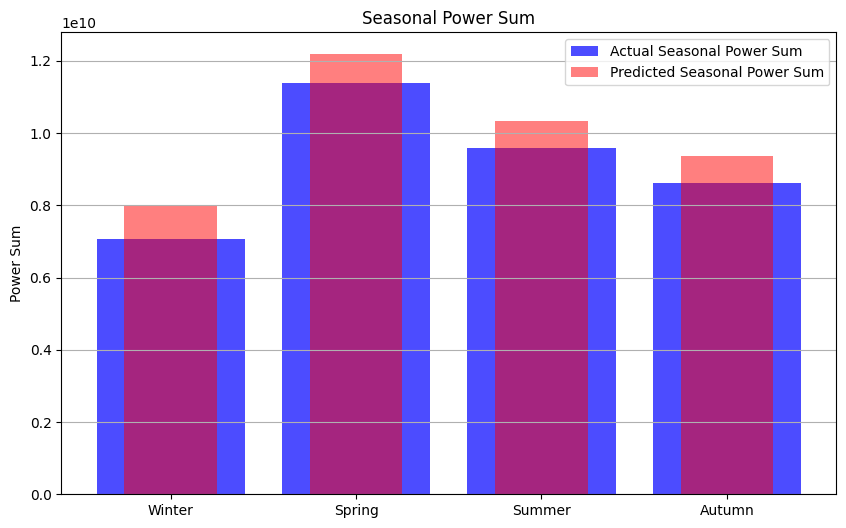

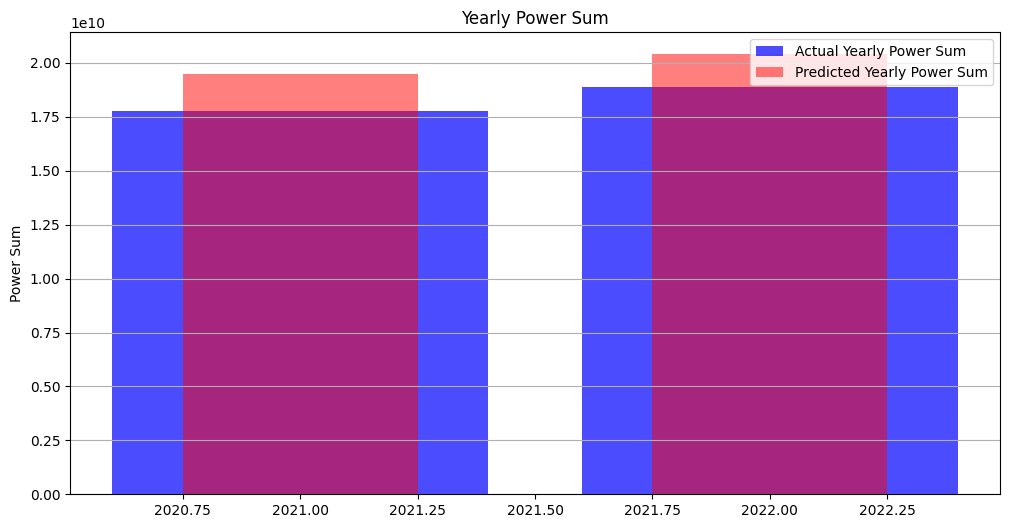

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming the 'Month' and 'Year' columns are present in the test_data
# We also assume that 'oof_test_preds' is the array of predictions for the test_data

def assign_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'
    else:
        return 'Winter'

# 1. Monthly Bar Plot
grouped_by_month = test.groupby('Month')
monthly_actual_sum = grouped_by_month['power'].sum().values
monthly_predicted_sum = [np.sum(oof_test_preds[grouped_by_month.indices[key]]) for key in range(1, 13)]

plt.figure(figsize=(12, 6))
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.bar(months, monthly_actual_sum, label='Actual Monthly Power Sum', color='blue', alpha=0.7)
plt.bar(months, monthly_predicted_sum, label='Predicted Monthly Power Sum', color='red', alpha=0.5, width=0.5)
plt.title('Monthly Power Sum')
plt.ylabel('Power Sum')
plt.legend()
plt.grid(True, axis='y')
plt.show()

# 2. Seasonal Bar Plot (Using the provided function)
test['Season'] = test['Month'].apply(assign_season)
grouped_by_season = test.groupby('Season')
seasonal_actual_sum = grouped_by_season['power'].sum().reindex(['Winter', 'Spring', 'Summer', 'Autumn']).values
seasonal_predicted_sum = [np.sum(oof_test_preds[grouped_by_season.indices[key]]) for key in ['Winter', 'Spring', 'Summer', 'Autumn']]

plt.figure(figsize=(10, 6))
plt.bar(['Winter', 'Spring', 'Summer', 'Autumn'], seasonal_actual_sum, label='Actual Seasonal Power Sum', color='blue', alpha=0.7)
plt.bar(['Winter', 'Spring', 'Summer', 'Autumn'], seasonal_predicted_sum, label='Predicted Seasonal Power Sum', color='red', alpha=0.5, width=0.5)
plt.title('Seasonal Power Sum')
plt.ylabel('Power Sum')
plt.legend()
plt.grid(True, axis='y')
plt.show()

# 3. Yearly Bar Plot
grouped_by_year = test.groupby('Year')
yearly_actual_sum = grouped_by_year['power'].sum().values
years = grouped_by_year.groups.keys()
yearly_predicted_sum = [np.sum(oof_test_preds[grouped_by_year.indices[key]]) for key in years]

plt.figure(figsize=(12, 6))
plt.bar(years, yearly_actual_sum, label='Actual Yearly Power Sum', color='blue', alpha=0.7)
plt.bar(years, yearly_predicted_sum, label='Predicted Yearly Power Sum', color='red', alpha=0.5, width=0.5)
plt.title('Yearly Power Sum')
plt.ylabel('Power Sum')
plt.legend()
plt.grid(True, axis='y')
plt.show()


# Delete columns

In [33]:
train = pd.read_csv('train_data_nan.csv', index_col='DateTime')
test = pd.read_csv('test_data_nan.csv', index_col = 'DateTime')

rmse_results = {}

train.fillna(-1, inplace=True)
test.fillna(-1, inplace=True)

all_data = pd.concat([train, test], ignore_index = True)
all_data = all_data.drop(columns=["Day", "Year", "t2m", "power", "CloudForm", "GroundState(code)", "PhenomenonNumber"])
all_data_origin = all_data

for column in all_data.columns:
    all_data = all_data_origin.drop(columns = [column])
    print(f"*********************************delete {column}")

    all_data['num_missing'] = (all_data == -1).sum(axis=1)

    all_data_sprs = sparse.hstack([sparse.csr_matrix(all_data)],
                                  format = 'csr')
    num_train = len(train)
    X = all_data_sprs[:num_train]
    X_test = all_data_sprs[num_train:]
    y = train['power'].values
    y_test = test['power'].values
    
    xgb_oof_val_preds = np.zeros(X.shape[0])
    xgb_oof_test_preds = np.zeros(X_test.shape[0])

    folds = TimeSeriesSplit(n_splits=5)

    for train_idx, valid_idx in folds.split(X, y) : 
        X_train, y_train = X[train_idx], y[train_idx]
        X_valid, y_valid = X[valid_idx], y[valid_idx]

        xgb_model = XGBRegressor(**xgb_params) 
        xgb_model.set_params(early_stopping_rounds = 300,
                             eval_metric = 'rmse')
        xgb_model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)],
                     verbose = False)

        xgb_oof_test_preds += xgb_model.predict(X_test)/folds.n_splits
        xgb_oof_val_preds[valid_idx] += xgb_model.predict(X_valid)

        xgb_score = evaluation_metric(y_valid, xgb_oof_val_preds[valid_idx])
        print(f"validation fold RMSE: {xgb_score:.4f}")

        xgb_nrmse_score = nrmse(y_valid, xgb_oof_val_preds[valid_idx])
        print(f"Normalized Validation fold RMSE: {xgb_nrmse_score:.4f}")
        
    xgb_score = evaluation_metric(y_test, xgb_oof_test_preds)
    print(f"test RMSE: {xgb_score:.4f}")
    print(f"test error percentage : {test_error_percentage(xgb_score):.4f}")

    xgb_nrmse_score = nrmse(y_test, xgb_oof_test_preds)
    print(f"Normalized test RMSE: {xgb_nrmse_score:.4f}")
    
    rmse_results[column] = xgb_score

*********************************delete Month
validation fold RMSE: 761036.4312
Normalized Validation fold RMSE: 0.0642
validation fold RMSE: 761971.2620
Normalized Validation fold RMSE: 0.0635
validation fold RMSE: 750115.8664
Normalized Validation fold RMSE: 0.0614
validation fold RMSE: 810157.9859
Normalized Validation fold RMSE: 0.0655
validation fold RMSE: 772816.6689
Normalized Validation fold RMSE: 0.0643
test RMSE: 842064.7682
test error percentage : 20.5132
Normalized test RMSE: 0.0693
*********************************delete Hour
validation fold RMSE: 813063.8884
Normalized Validation fold RMSE: 0.0686
validation fold RMSE: 812164.0291
Normalized Validation fold RMSE: 0.0677
validation fold RMSE: 811957.3220
Normalized Validation fold RMSE: 0.0664
validation fold RMSE: 932248.0635
Normalized Validation fold RMSE: 0.0753
validation fold RMSE: 839497.7839
Normalized Validation fold RMSE: 0.0698
test RMSE: 957235.6164
test error percentage : 23.3188
Normalized test RMSE: 0.0788
*

validation fold RMSE: 757337.5397
Normalized Validation fold RMSE: 0.0639
validation fold RMSE: 764731.3322
Normalized Validation fold RMSE: 0.0638
validation fold RMSE: 749798.2686
Normalized Validation fold RMSE: 0.0614
validation fold RMSE: 812641.5910
Normalized Validation fold RMSE: 0.0657
validation fold RMSE: 767353.1766
Normalized Validation fold RMSE: 0.0638
test RMSE: 844136.0451
test error percentage : 20.5636
Normalized test RMSE: 0.0695


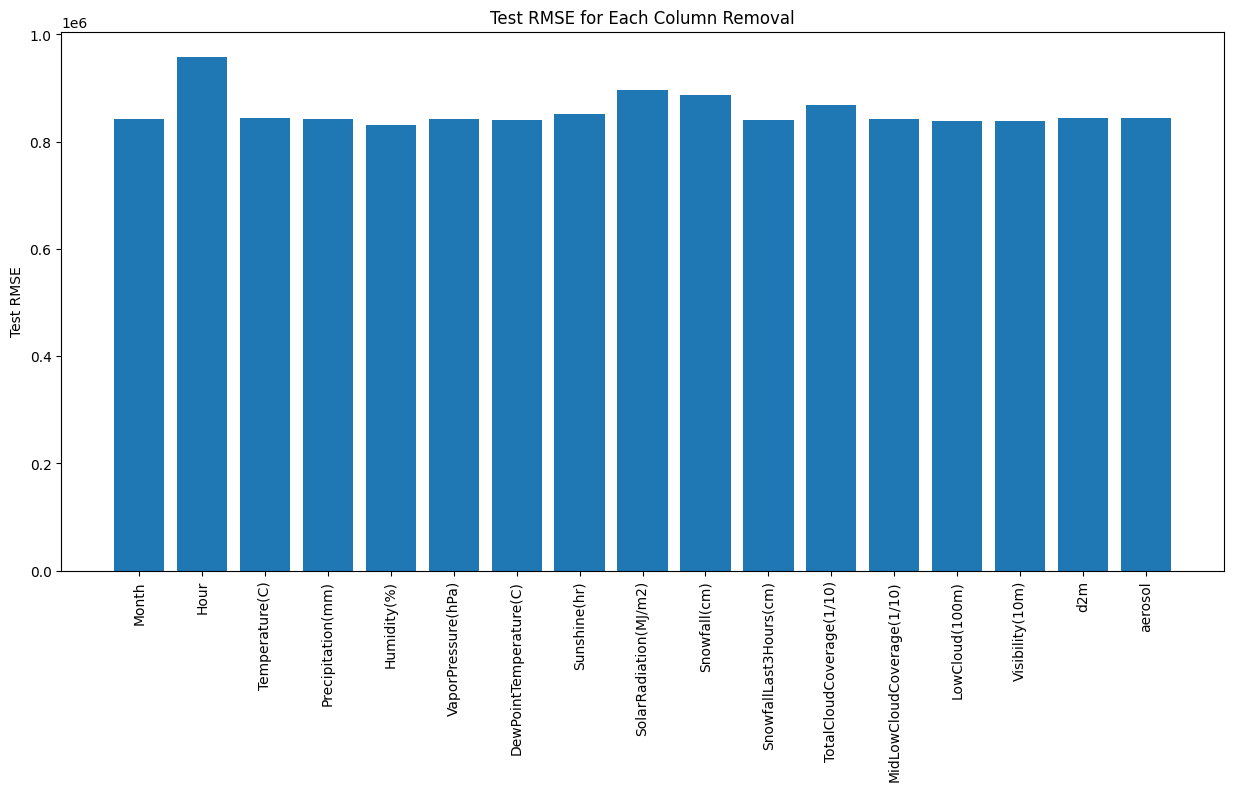

In [34]:
plt.figure(figsize=(15, 7))
plt.bar(rmse_results.keys(), rmse_results.values())
plt.xticks(rotation=90)
plt.ylabel('Test RMSE')
plt.title('Test RMSE for Each Column Removal')
plt.axhline(y=846400, color='r', linestyle='--', label="Reference RMSE: 931521.0182")
plt.legend()
plt.ylim(800900, 1000000)  # Adjust the y-axis limits to zoom in on the data
plt.show()

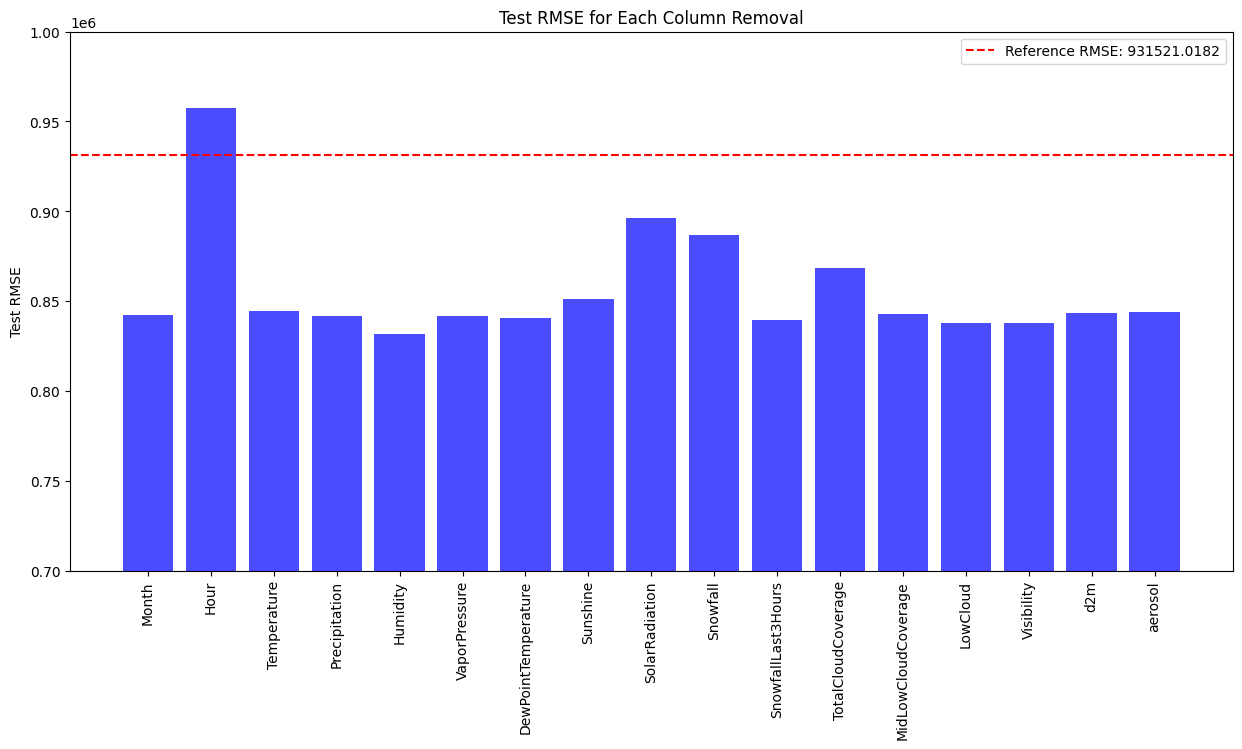

In [29]:
import re

# Given data as a string
data = """
*********************************delete Month
validation fold RMSE: 761036.4312
Normalized Validation fold RMSE: 0.0642
validation fold RMSE: 761971.2620
Normalized Validation fold RMSE: 0.0635
validation fold RMSE: 750115.8664
Normalized Validation fold RMSE: 0.0614
validation fold RMSE: 810157.9859
Normalized Validation fold RMSE: 0.0655
validation fold RMSE: 772816.6689
Normalized Validation fold RMSE: 0.0643
test RMSE: 842064.7682
test error percentage : 20.5132
Normalized test RMSE: 0.0693
*********************************delete Hour
validation fold RMSE: 813063.8884
Normalized Validation fold RMSE: 0.0686
validation fold RMSE: 812164.0291
Normalized Validation fold RMSE: 0.0677
validation fold RMSE: 811957.3220
Normalized Validation fold RMSE: 0.0664
validation fold RMSE: 932248.0635
Normalized Validation fold RMSE: 0.0753
validation fold RMSE: 839497.7839
Normalized Validation fold RMSE: 0.0698
test RMSE: 957235.6164
test error percentage : 23.3188
Normalized test RMSE: 0.0788
*********************************delete Temperature(C)
validation fold RMSE: 756846.2271
Normalized Validation fold RMSE: 0.0639
validation fold RMSE: 767599.5233
Normalized Validation fold RMSE: 0.0640
validation fold RMSE: 751357.5097
Normalized Validation fold RMSE: 0.0615
validation fold RMSE: 812794.8858
Normalized Validation fold RMSE: 0.0657
validation fold RMSE: 769920.7414
Normalized Validation fold RMSE: 0.0641
test RMSE: 844577.0571
test error percentage : 20.5744
Normalized test RMSE: 0.0695
*********************************delete Precipitation(mm)
validation fold RMSE: 757905.6110
Normalized Validation fold RMSE: 0.0640
validation fold RMSE: 764971.3721
Normalized Validation fold RMSE: 0.0638
validation fold RMSE: 752810.2334
Normalized Validation fold RMSE: 0.0616
validation fold RMSE: 811913.7513
Normalized Validation fold RMSE: 0.0656
validation fold RMSE: 767328.5534
Normalized Validation fold RMSE: 0.0638
test RMSE: 841764.8315
test error percentage : 20.5059
Normalized test RMSE: 0.0693
*********************************delete Humidity(%)
validation fold RMSE: 763953.1740
Normalized Validation fold RMSE: 0.0645
validation fold RMSE: 766339.5191
Normalized Validation fold RMSE: 0.0639
validation fold RMSE: 754431.0102
Normalized Validation fold RMSE: 0.0617
validation fold RMSE: 804156.2452
Normalized Validation fold RMSE: 0.0650
validation fold RMSE: 763759.5997
Normalized Validation fold RMSE: 0.0635
test RMSE: 831695.5531
test error percentage : 20.2606
Normalized test RMSE: 0.0685
*********************************delete VaporPressure(hPa)
validation fold RMSE: 756867.4287
Normalized Validation fold RMSE: 0.0639
validation fold RMSE: 763388.2233
Normalized Validation fold RMSE: 0.0637
validation fold RMSE: 752458.5839
Normalized Validation fold RMSE: 0.0616
validation fold RMSE: 812398.8982
Normalized Validation fold RMSE: 0.0657
validation fold RMSE: 767519.3687
Normalized Validation fold RMSE: 0.0639
test RMSE: 841714.2352
test error percentage : 20.5046
Normalized test RMSE: 0.0693
*********************************delete DewPointTemperature(C)
validation fold RMSE: 756124.6463
Normalized Validation fold RMSE: 0.0638
validation fold RMSE: 763625.8925
Normalized Validation fold RMSE: 0.0637
validation fold RMSE: 751838.4165
Normalized Validation fold RMSE: 0.0615
validation fold RMSE: 812226.2070
Normalized Validation fold RMSE: 0.0656
validation fold RMSE: 767427.7323
Normalized Validation fold RMSE: 0.0639
test RMSE: 840567.0362
test error percentage : 20.4767
Normalized test RMSE: 0.0692
*********************************delete Sunshine(hr)
validation fold RMSE: 768644.1535
Normalized Validation fold RMSE: 0.0649
validation fold RMSE: 772602.4421
Normalized Validation fold RMSE: 0.0644
validation fold RMSE: 768600.3508
Normalized Validation fold RMSE: 0.0629
validation fold RMSE: 818290.0566
Normalized Validation fold RMSE: 0.0661
validation fold RMSE: 765084.5157
Normalized Validation fold RMSE: 0.0637
test RMSE: 851187.5721
test error percentage : 20.7354
Normalized test RMSE: 0.0701
*********************************delete SolarRadiation(MJ/m2)
validation fold RMSE: 865130.6151
Normalized Validation fold RMSE: 0.0730
validation fold RMSE: 885027.1681
Normalized Validation fold RMSE: 0.0738
validation fold RMSE: 873335.4288
Normalized Validation fold RMSE: 0.0715
validation fold RMSE: 897856.2288
Normalized Validation fold RMSE: 0.0726
validation fold RMSE: 814716.4384
Normalized Validation fold RMSE: 0.0678
test RMSE: 896483.5823
test error percentage : 21.8388
Normalized test RMSE: 0.0738
*********************************delete Snowfall(cm)
validation fold RMSE: 764889.1291
Normalized Validation fold RMSE: 0.0646
validation fold RMSE: 792173.3082
Normalized Validation fold RMSE: 0.0661
validation fold RMSE: 816634.6233
Normalized Validation fold RMSE: 0.0668
validation fold RMSE: 823688.4643
Normalized Validation fold RMSE: 0.0666
validation fold RMSE: 777843.5826
Normalized Validation fold RMSE: 0.0647
test RMSE: 886702.1681
test error percentage : 21.6006
Normalized test RMSE: 0.0730
*********************************delete SnowfallLast3Hours(cm)
validation fold RMSE: 758358.6834
Normalized Validation fold RMSE: 0.0640
validation fold RMSE: 763327.6886
Normalized Validation fold RMSE: 0.0637
validation fold RMSE: 749842.9666
Normalized Validation fold RMSE: 0.0614
validation fold RMSE: 810680.8417
Normalized Validation fold RMSE: 0.0655
validation fold RMSE: 767514.4549
Normalized Validation fold RMSE: 0.0639
test RMSE: 839583.1861
test error percentage : 20.4527
Normalized test RMSE: 0.0691
*********************************delete TotalCloudCoverage(1/10)
validation fold RMSE: 773319.3300
Normalized Validation fold RMSE: 0.0653
validation fold RMSE: 773160.1975
Normalized Validation fold RMSE: 0.0645
validation fold RMSE: 759727.5769
Normalized Validation fold RMSE: 0.0622
validation fold RMSE: 827576.0599
Normalized Validation fold RMSE: 0.0669
validation fold RMSE: 782839.0268
Normalized Validation fold RMSE: 0.0651
test RMSE: 868399.5055
test error percentage : 21.1547
Normalized test RMSE: 0.0715
*********************************delete MidLowCloudCoverage(1/10)
validation fold RMSE: 760493.2741
Normalized Validation fold RMSE: 0.0642
validation fold RMSE: 764797.1583
Normalized Validation fold RMSE: 0.0638
validation fold RMSE: 748247.0228
Normalized Validation fold RMSE: 0.0612
validation fold RMSE: 813000.2851
Normalized Validation fold RMSE: 0.0657
validation fold RMSE: 768194.1773
Normalized Validation fold RMSE: 0.0639
test RMSE: 842621.8175
test error percentage : 20.5267
Normalized test RMSE: 0.0694
*********************************delete LowCloud(100m)
validation fold RMSE: 758141.3563
Normalized Validation fold RMSE: 0.0640
validation fold RMSE: 763514.7861
Normalized Validation fold RMSE: 0.0637
validation fold RMSE: 752468.9275
Normalized Validation fold RMSE: 0.0616
validation fold RMSE: 812002.1051
Normalized Validation fold RMSE: 0.0656
validation fold RMSE: 768700.8654
Normalized Validation fold RMSE: 0.0640
test RMSE: 838102.3909
test error percentage : 20.4166
Normalized test RMSE: 0.0690
*********************************delete Visibility(10m)
validation fold RMSE: 761084.5884
Normalized Validation fold RMSE: 0.0642
validation fold RMSE: 761171.3799
Normalized Validation fold RMSE: 0.0635
validation fold RMSE: 749849.5004
Normalized Validation fold RMSE: 0.0614
validation fold RMSE: 812132.8243
Normalized Validation fold RMSE: 0.0656
validation fold RMSE: 770754.3652
Normalized Validation fold RMSE: 0.0641
test RMSE: 837983.1187
test error percentage : 20.4137
Normalized test RMSE: 0.0690
*********************************delete d2m
validation fold RMSE: 763928.7293
Normalized Validation fold RMSE: 0.0645
validation fold RMSE: 763797.9267
Normalized Validation fold RMSE: 0.0637
validation fold RMSE: 750691.9346
Normalized Validation fold RMSE: 0.0614
validation fold RMSE: 813394.5165
Normalized Validation fold RMSE: 0.0657
validation fold RMSE: 770469.4160
Normalized Validation fold RMSE: 0.0641
test RMSE: 843508.0901
test error percentage : 20.5483
Normalized test RMSE: 0.0695
*********************************delete aerosol
validation fold RMSE: 757337.5397
Normalized Validation fold RMSE: 0.0639
validation fold RMSE: 764731.3322
Normalized Validation fold RMSE: 0.0638
validation fold RMSE: 749798.2686
Normalized Validation fold RMSE: 0.0614
validation fold RMSE: 812641.5910
Normalized Validation fold RMSE: 0.0657
validation fold RMSE: 767353.1766
Normalized Validation fold RMSE: 0.0638
test RMSE: 844136.0451
test error percentage : 20.5636
Normalized test RMSE: 0.0695
"""

# Extracting the column names and their corresponding RMSE values
columns = re.findall(r"delete (\w+)", data)
rmse_values = re.findall(r"test RMSE: (\d+\.\d+)", data)[::2]  # Use slicing to skip every second value

# Creating a dictionary to store the results
rmse_results = {column: float(rmse) for column, rmse in zip(columns, rmse_values)}

# Plotting
plt.figure(figsize=(15, 7))
plt.bar(rmse_results.keys(), rmse_results.values(), color='blue', alpha=0.7)
plt.xticks(rotation=90)
plt.ylabel('Test RMSE')
plt.title('Test RMSE for Each Column Removal')
plt.axhline(y=931521.0182, color='r', linestyle='--', label="Reference RMSE: 931521.0182")
plt.legend()
plt.ylim(700000, 1000000)  # Adjust the y-axis limits to zoom in on the data
plt.show()

# Catboost optuna

In [37]:
# Optuna Libraries
import optuna
from optuna import Trial
from optuna.samplers import TPESampler

# LGBM Regressor
from catboost import CatBoostRegressor

# train_test_split
from sklearn.model_selection import train_test_split

# Evaluation Score
from sklearn.metrics import mean_squared_error

In [38]:
train = pd.read_csv('train_data_nan.csv', index_col='DateTime')
test = pd.read_csv('test_data_nan.csv', index_col = 'DateTime')

train.fillna(-1, inplace=True)
test.fillna(-1, inplace=True)

all_data = pd.concat([train, test], ignore_index = False)
all_data = all_data.drop(columns=["Day", "Year", "t2m", "power", 
                                  "CloudForm", "GroundState(code)", "PhenomenonNumber",
                                 "Humidity(%)", "Visibility(10m)",
                                 "aerosol"])
all_data['num_missing'] = (all_data == -1).sum(axis=1)
all_data.head()

,Month,Hour,Temperature(C),Precipitation(mm),VaporPressure(hPa),DewPointTemperature(C),Sunshine(hr),SolarRadiation(MJ/m2),Snowfall(cm),SnowfallLast3Hours(cm),TotalCloudCoverage(1/10),MidLowCloudCoverage(1/10),LowCloud(100m),d2m,num_missing
DateTime,,,,,,,,,,,,,,,
2013-03-19 07:00:00,3,7,6.4,-1.0,9.5,6.2,0.0,0.01,-1.0,-1.0,7.0,7.0,10.0,281.82224,3
2013-03-19 08:00:00,3,8,7.2,-1.0,9.7,6.5,0.0,0.24,-1.0,-1.0,7.0,7.0,10.0,281.86746,3
2013-03-19 09:00:00,3,9,9.1,-1.0,10.4,7.5,0.3,0.73,-1.0,-1.0,3.0,3.0,10.0,282.04712,3
2013-03-19 10:00:00,3,10,11.1,-1.0,10.4,7.5,1.0,1.34,-1.0,-1.0,0.0,0.0,-1.0,282.88538,4
2013-03-19 11:00:00,3,11,12.9,-1.0,10.9,8.3,1.0,1.82,-1.0,-1.0,0.0,0.0,-1.0,282.98697,4


In [43]:
train.head()

,Month,Day,Hour,Temperature(C),Precipitation(mm),Humidity(%),VaporPressure(hPa),DewPointTemperature(C),Sunshine(hr),SolarRadiation(MJ/m2),...,CloudForm,LowCloud(100m),Visibility(10m),GroundState(code),PhenomenonNumber,d2m,t2m,aerosol,power,Year
DateTime,,,,,,,,,,,,,,,,,,,,,
2013-03-19 07:00:00,3,19,7,6.4,-1.0,99.0,9.5,6.2,0.0,0.01,...,Sc,10.0,300.0,-1.0,19.0,281.82224,286.23135,102.0,9600.0,2013
2013-03-19 08:00:00,3,19,8,7.2,-1.0,96.0,9.7,6.5,0.0,0.24,...,Sc,10.0,300.0,-1.0,4219.0,281.86746,285.86597,108.0,816000.0,2013
2013-03-19 09:00:00,3,19,9,9.1,-1.0,90.0,10.4,7.5,0.3,0.73,...,Sc,10.0,300.0,1.0,4219.0,282.04712,285.64914,100.0,2899200.0,2013
2013-03-19 10:00:00,3,19,10,11.1,-1.0,79.0,10.4,7.5,1.0,1.34,...,-1,-1.0,400.0,-1.0,4219.0,282.88538,284.99387,94.0,5472000.0,2013
2013-03-19 11:00:00,3,19,11,12.9,-1.0,74.0,10.9,8.3,1.0,1.82,...,-1,-1.0,400.0,-1.0,4219.0,282.98697,284.90920,80.0,7401600.0,2013


In [44]:
drop_columns = ["Day", "Year", "t2m", "power", "CloudForm", "GroundState(code)", 
                    "PhenomenonNumber", "Humidity(%)", "Visibility(10m)", "aerosol"]
X_train = train.drop(columns=drop_columns)
y_train = train['power']
X_val = test.drop(columns=drop_columns)
y_val = test['power']

In [45]:
# random sampler
sampler = TPESampler(seed=10)

# define function
def objective(trial):

    cbrm_param = {
        'iterations':trial.suggest_int("iterations", 4000, 25000),
        'od_wait':trial.suggest_int('od_wait', 500, 2300),
        'learning_rate' : trial.suggest_uniform('learning_rate',0.01, 1),
        'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
        'subsample': trial.suggest_uniform('subsample',0,1),
        'random_strength': trial.suggest_uniform('random_strength',10,50),
        'depth': trial.suggest_int('depth',1, 15),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,30),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
        'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
        'colsample_bylevel':trial.suggest_float('colsample_bylevel', 0.4, 1.0),
    }

    # Generate model
    model_cbrm = CatBoostRegressor(**cbrm_param)
    model_cbrm = model_cbrm.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
                           verbose=0, early_stopping_rounds=25)
                           
	# 평가지표 원하는 평가 지표가 있을 시 바꾸어 준다.
    RMSE = evaluation_metric(y_val, model_cbrm.predict(X_val))
    return RMSE

optuna_cbrm = optuna.create_study(direction='minimize', sampler=sampler)
optuna_cbrm.optimize(objective, n_trials=50)

[I 2023-09-04 13:09:07,924] A new study created in memory with name: no-name-570f4376-53b5-4f9e-a22e-63d7b69a54d9
C:\Users\sedag\AppData\Local\Temp\ipykernel_23600\3825758323.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate' : trial.suggest_uniform('learning_rate',0.01, 1),
C:\Users\sedag\AppData\Local\Temp\ipykernel_23600\3825758323.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
C:\Users\sedag\AppData\Local\Temp\ipykernel_23600\3825758323.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float 

C:\Users\sedag\AppData\Local\Temp\ipykernel_23600\3825758323.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate' : trial.suggest_uniform('learning_rate',0.01, 1),
C:\Users\sedag\AppData\Local\Temp\ipykernel_23600\3825758323.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
C:\Users\sedag\AppData\Local\Temp\ipykernel_23600\3825758323.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample',0,1),
C:\Users\sedag\AppData\Local\Temp\ipykernel_23600\

C:\Users\sedag\AppData\Local\Temp\ipykernel_23600\3825758323.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate' : trial.suggest_uniform('learning_rate',0.01, 1),
C:\Users\sedag\AppData\Local\Temp\ipykernel_23600\3825758323.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
C:\Users\sedag\AppData\Local\Temp\ipykernel_23600\3825758323.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample',0,1),
C:\Users\sedag\AppData\Local\Temp\ipykernel_23600\

C:\Users\sedag\AppData\Local\Temp\ipykernel_23600\3825758323.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate' : trial.suggest_uniform('learning_rate',0.01, 1),
C:\Users\sedag\AppData\Local\Temp\ipykernel_23600\3825758323.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
C:\Users\sedag\AppData\Local\Temp\ipykernel_23600\3825758323.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample',0,1),
C:\Users\sedag\AppData\Local\Temp\ipykernel_23600\

C:\Users\sedag\AppData\Local\Temp\ipykernel_23600\3825758323.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate' : trial.suggest_uniform('learning_rate',0.01, 1),
C:\Users\sedag\AppData\Local\Temp\ipykernel_23600\3825758323.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
C:\Users\sedag\AppData\Local\Temp\ipykernel_23600\3825758323.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample',0,1),
C:\Users\sedag\AppData\Local\Temp\ipykernel_23600\

C:\Users\sedag\AppData\Local\Temp\ipykernel_23600\3825758323.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate' : trial.suggest_uniform('learning_rate',0.01, 1),
C:\Users\sedag\AppData\Local\Temp\ipykernel_23600\3825758323.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
C:\Users\sedag\AppData\Local\Temp\ipykernel_23600\3825758323.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample',0,1),
C:\Users\sedag\AppData\Local\Temp\ipykernel_23600\

C:\Users\sedag\AppData\Local\Temp\ipykernel_23600\3825758323.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate' : trial.suggest_uniform('learning_rate',0.01, 1),
C:\Users\sedag\AppData\Local\Temp\ipykernel_23600\3825758323.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
C:\Users\sedag\AppData\Local\Temp\ipykernel_23600\3825758323.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample',0,1),
C:\Users\sedag\AppData\Local\Temp\ipykernel_23600\

C:\Users\sedag\AppData\Local\Temp\ipykernel_23600\3825758323.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate' : trial.suggest_uniform('learning_rate',0.01, 1),
C:\Users\sedag\AppData\Local\Temp\ipykernel_23600\3825758323.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
C:\Users\sedag\AppData\Local\Temp\ipykernel_23600\3825758323.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample',0,1),
C:\Users\sedag\AppData\Local\Temp\ipykernel_23600\

C:\Users\sedag\AppData\Local\Temp\ipykernel_23600\3825758323.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate' : trial.suggest_uniform('learning_rate',0.01, 1),
C:\Users\sedag\AppData\Local\Temp\ipykernel_23600\3825758323.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
C:\Users\sedag\AppData\Local\Temp\ipykernel_23600\3825758323.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample',0,1),
C:\Users\sedag\AppData\Local\Temp\ipykernel_23600\

C:\Users\sedag\AppData\Local\Temp\ipykernel_23600\3825758323.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate' : trial.suggest_uniform('learning_rate',0.01, 1),
C:\Users\sedag\AppData\Local\Temp\ipykernel_23600\3825758323.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
C:\Users\sedag\AppData\Local\Temp\ipykernel_23600\3825758323.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample',0,1),
C:\Users\sedag\AppData\Local\Temp\ipykernel_23600\

C:\Users\sedag\AppData\Local\Temp\ipykernel_23600\3825758323.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate' : trial.suggest_uniform('learning_rate',0.01, 1),
C:\Users\sedag\AppData\Local\Temp\ipykernel_23600\3825758323.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
C:\Users\sedag\AppData\Local\Temp\ipykernel_23600\3825758323.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample',0,1),
C:\Users\sedag\AppData\Local\Temp\ipykernel_23600\

C:\Users\sedag\AppData\Local\Temp\ipykernel_23600\3825758323.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate' : trial.suggest_uniform('learning_rate',0.01, 1),
C:\Users\sedag\AppData\Local\Temp\ipykernel_23600\3825758323.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
C:\Users\sedag\AppData\Local\Temp\ipykernel_23600\3825758323.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample',0,1),
C:\Users\sedag\AppData\Local\Temp\ipykernel_23600\

C:\Users\sedag\AppData\Local\Temp\ipykernel_23600\3825758323.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate' : trial.suggest_uniform('learning_rate',0.01, 1),
C:\Users\sedag\AppData\Local\Temp\ipykernel_23600\3825758323.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
C:\Users\sedag\AppData\Local\Temp\ipykernel_23600\3825758323.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample',0,1),
C:\Users\sedag\AppData\Local\Temp\ipykernel_23600\

In [46]:
cbrm_trial = optuna_cbrm.best_trial
cbrm_trial_params = cbrm_trial.params
print('Best Trial: score {},\nparams {}'.format(cbrm_trial.value, cbrm_trial_params))

Best Trial: score 781959.1408019337,
params {'iterations': 16548, 'od_wait': 2242, 'learning_rate': 0.07657517567155654, 'reg_lambda': 52.990624904606946, 'subsample': 0.39588132302781154, 'random_strength': 22.033396044005116, 'depth': 6, 'min_data_in_leaf': 9, 'leaf_estimation_iterations': 15, 'bagging_temperature': 0.03433731559190882, 'colsample_bylevel': 0.40040885299385404}


In [47]:
cbrm_trial_params

{'iterations': 16548,
 'od_wait': 2242,
 'learning_rate': 0.07657517567155654,
 'reg_lambda': 52.990624904606946,
 'subsample': 0.39588132302781154,
 'random_strength': 22.033396044005116,
 'depth': 6,
 'min_data_in_leaf': 9,
 'leaf_estimation_iterations': 15,
 'bagging_temperature': 0.03433731559190882,
 'colsample_bylevel': 0.40040885299385404}

In [ ]:
from sklearn.preprocessing import StandardScaler
train = pd.read_csv('train_data_nan.csv', index_col='DateTime')
test = pd.read_csv('test_data_nan.csv', index_col='DateTime')
train.fillna(-1, inplace=True)
test.fillna(-1, inplace=True)
all_data = pd.concat([train, test], ignore_index=True)
all_data['Precipitation(mm)'] = all_data['Precipitation(mm)'] + 0.001
drop_columns = ["Day", "Year", "t2m", "CloudForm", "GroundState(code)", 
                "PhenomenonNumber", "Humidity(%)", "Visibility(10m)", "aerosol"]
all_data = all_data.drop(columns=drop_columns)
all_data['num_missing'] = (all_data == -1).sum(axis=1)

log_cols = ['Precipitation(mm)', 'power']
for col in log_cols:
    all_data[col] = np.log1p(all_data[col])  # log(1+x) transformation to handle zeros

standard_cols = ['VaporPressure(hPa)', 'Sunshine(hr)', 
             'SolarRadiation(MJ/m2)', 'Snowfall(cm)', 'TotalCloudCoverage(1/10)']
scaler = StandardScaler()
all_data[standard_cols] = scaler.fit_transform(all_data[standard_cols])
all_data.head()
